## Image Classification with CNNs

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/packt_nlp_tensorflow_2/blob/master/Ch05-Sentence-Classification/ch5_image_classification_fashion_mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Required for Data downaload and preparation
import struct
import gzip
import os
from six.moves.urllib.request import urlretrieve


%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


# Download data

On Linux, data is downloaded to `~/.keras/dataset/fasion_minst` folder

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 2s 0us/step


# Analysing data

In [3]:
print(f"train_images is of shape: {train_images.shape}")
print(f"train_labels is of shape: {train_labels.shape}")
print(f"test_images is of shape: {test_images.shape}")
print(f"test_labels is of shape: {test_labels.shape}")

# Available at: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

train_images is of shape: (60000, 28, 28)
train_labels is of shape: (60000,)
test_images is of shape: (10000, 28, 28)
test_labels is of shape: (10000,)


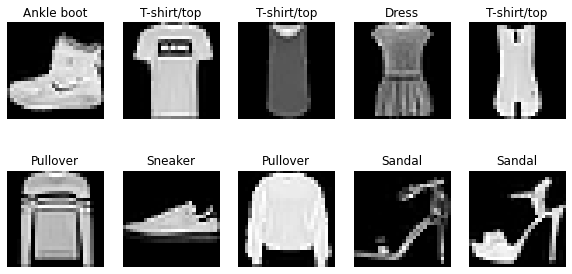

In [4]:
n_rows = 2
n_cols = 5
f, axes = plt.subplots(n_rows, n_cols, figsize=(10,5))

for row in range(len(axes)):
    for col in range(len(axes[row])):
    
        axes[row][col].imshow(train_images[row*n_cols+col, :, :], cmap=plt.get_cmap('gray'))
        axes[row][col].set_title(label_map[train_labels[row*n_cols+col]])
        axes[row][col].axis('off')
        

In [5]:
train_images = train_images[:, : , :, None]
test_images = test_images[:, : ,: , None]

print(f"train_images is of shape: {train_images.shape}")
print(f"train_labels is of shape: {train_labels.shape}")
print(f"test_images is of shape: {test_images.shape}")
print(f"test_labels is of shape: {test_labels.shape}")

train_images is of shape: (60000, 28, 28, 1)
train_labels is of shape: (60000,)
test_images is of shape: (10000, 28, 28, 1)
test_labels is of shape: (10000,)


## Defining Hyperparameters

Here we define the set of hyperparameters we're going to you in our example. These hyperparameters include `batch_size`, `image_size`, etc.

In [6]:
batch_size = 100 # This is the typical batch size we've been using

image_size = 28 # This is the width/height of a single image

# Number of color channels in an image. These are black and white images 
n_channels = 1 

# Number of different digits we have images for (i.e. classes)
n_classes = 10

## Conceptual explanation of CNN operations

---
*Conceptual illustration of the convolution operation*

![Conceptual illustration of the convolution operation](notebook_images/05_01.png)

---
*Conceptual illustration of the max-pooling operation*

![Conceptual illustration of the max-pooling operation](notebook_images/05_02.png)

## Defining Model Parameters and Other Variables
Here we define the CNN model we will be using. The model is inspired by the [LeNet model](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), one of the earliest CNN models.

---
*Convolution operation*

![Convolution operation](notebook_images/05_05.png)

---
*Max pool operation*

![Max-pool operation](notebook_images/05_08.png)

---
*Average-pool operation*

![Average-pool operation](notebook_images/05_10.png)


In [7]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

K.clear_session()

lenet_like_model = Sequential([
    # 1st convolutional layer
    Conv2D(
        filters=16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu', 
        input_shape=(image_size,image_size,n_channels)
    ), # in 28x28 / out 24x24
    # 1st max pooling layer
    MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'), # in 24x24 / out 12x12
    # 2nd convolutional layer
    Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'), # in 12x12 / out 8x8
    # 2nd max pooling layer
    MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'), # in 8x8 / out 4x4
    # 3rd convolutional layer
    Conv2D(filters=120, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu'), # in 4x4 / out 1x1
    # flatten the output of the last layer to suit a fully connected layer
    Flatten(),
    # First dense (fully-connected) layer
    Dense(84, activation='relu'),
    # Final prediction layer
    Dense(n_classes, activation='softmax')
])

# Compile with a loss and an optimizer
lenet_like_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary
lenet_like_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          6416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         30840     
                                                                 
 flatten (Flatten)           (None, 120)               0

## Defining Inference of the CNN
Here we define the computations starting from input placeholder (`tf_inputs`) and then computing the hidden activations for each of the layers found in `cnn_layer_ids` (i.e. convolution/pooling and fulcon layers) and their respective parameters (`layer_hyperparamters`). At the final layer (`softmax`) we do not apply an activation function as for the rest of the layers, but obtain the unnormalized logit values without any activation function.

## Define Accuracy 
A simple function to calculate accuracy for a given set of labels and predictions.

In [8]:
lenet_like_model.fit(train_images, train_labels, validation_split=0.2, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 63s 14ms/step - loss: 0.5796 - accuracy: 0.8041 - val_loss: 0.4340 - val_accuracy: 0.8420
Epoch 2/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3881 - accuracy: 0.8579 - val_loss: 0.3754 - val_accuracy: 0.8623
Epoch 3/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3476 - accuracy: 0.8700 - val_loss: 0.3772 - val_accuracy: 0.8593
Epoch 4/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3224 - accuracy: 0.8786 - val_loss: 0.3510 - val_accuracy: 0.8758
Epoch 5/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3024 - accuracy: 0.8869 - val_loss: 0.3823 - val_accuracy: 0.8563


In [9]:
lenet_like_model.evaluate(test_images, test_labels)

313/313 [==============================] - 4s 11ms/step - loss: 0.4079 - accuracy: 0.8535


[0.4079228937625885, 0.8535000085830688]

In [10]:
test_predictions = lenet_like_model.predict(test_images)

## Visualizing MNIST Results
Here we define a function to collect correctly and incorrectly classified samples to visualize later. Visualizing such samples will help us to understand why the CNN incorrectly classified certain samples.

In [11]:

def collect_correct_incorrect_samples(test_images, test_labels, test_predictions, n_correct=10, n_incorrect=10):
        

    # Visualization purposes
    correctly_predicted_images, correct_labels, correct_predictions = [], [], []
    incorrectly_predicted_images, incorrect_labels, incorrect_predictions = [], [], []
    
    test_predicted_labels = np.argmax(test_predictions, axis=-1)
    
    i_correct, i_incorrect = 0, 0
    for sample_image, sample_label, sample_prediction, sample_predicted_label  in zip(test_images, test_labels, test_predictions, test_predicted_labels):
        
        if i_correct < n_correct and sample_predicted_label == sample_label:
            correctly_predicted_images.append(sample_image[:, :, 0])
            correct_predictions.append(sample_prediction)
            correct_labels.append(sample_label)
            i_correct += 1
            
        if i_incorrect < n_incorrect and sample_predicted_label != sample_label:
            incorrectly_predicted_images.append(sample_image[:, :, 0])
            incorrect_predictions.append(sample_prediction)
            incorrect_labels.append(sample_label)
            i_incorrect += 1
            
        if i_correct >= n_correct and i_incorrect >= n_incorrect:
            break
            
    
    correctly_predicted_images = np.stack(correctly_predicted_images, axis=0)    
    correct_labels = np.array(correct_labels)
    correct_predictions = np.stack(correct_predictions, axis=0)
    incorrectly_predicted_images = np.stack(incorrectly_predicted_images, axis=0)
    incorrect_labels = np.array(incorrect_labels)
    incorrect_predictions = np.stack(incorrect_predictions, axis=0)

    return (correctly_predicted_images, correct_labels, correct_predictions), (incorrectly_predicted_images, incorrect_labels, incorrect_predictions)


(correctly_predicted_images, correct_labels, correct_predictions), \
    (incorrectly_predicted, incorrect_labels, incorrect_predictions) = collect_correct_incorrect_samples(test_images, test_labels, test_predictions)

In [12]:
correct_predictions[4,:]

array([8.9584194e-02, 4.4060839e-06, 7.0639625e-02, 1.0906974e-02,
       3.6648106e-02, 7.0692349e-06, 7.9120928e-01, 2.9146402e-05,
       9.6595276e-04, 5.2534697e-06], dtype=float32)

## Running MNIST Classification 
Here we train our CNN on MNIST data for `n_epochs` epochs. Each epoch we train the CNN with the full training dataset. Then we calculate the validation accuracy, according to which we decay the learning rate. Finally, each epoch we calculate the test accuracy which is computed using an independent test set. This code should run under 10 minutes if you run on a decent GPU and should reach to a test accuracy of about ~95%

## Visualizing Predictions
Let us see how when our CNN did when it comes to predictions


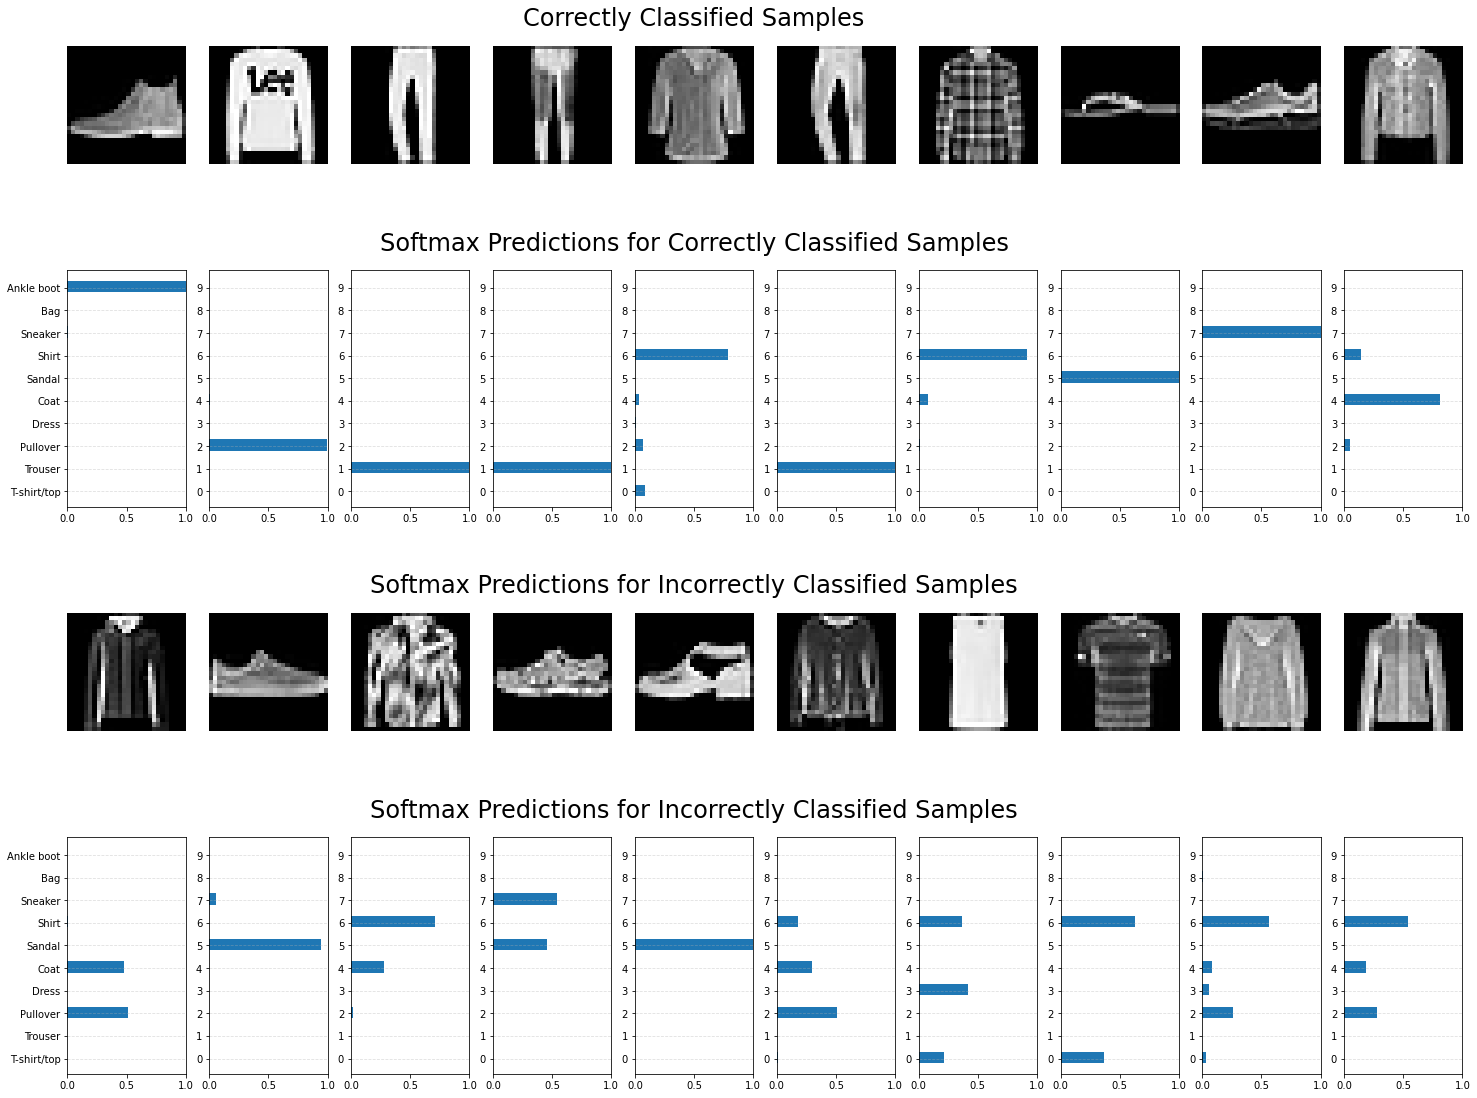

In [13]:
from math import ceil

def plot_correct_incorrect_instances(n_classes=10, label_map=None):
    
    (correctly_predicted_images, correct_labels, correct_predictions), \
    (incorrectly_predicted_images, incorrect_labels, incorrect_predictions) = collect_correct_incorrect_samples(test_images, test_labels, test_predictions)
        
    n_cols = correctly_predicted_images.shape[0]
    # Defining the plot related settings
    f, axes = plt.subplots(4, n_cols, figsize=(25,20))  # in inches
    
    width=0.5 # Width of a bar in the barchart
    padding = 0.05 # Padding between two bars
    
    labels = [label_map[i] for i in range(n_classes)]
    
    # Defining X axis
    x_axis = np.arange(0, n_classes)

    for row, axes_row in enumerate(axes):
        for col, ax in enumerate(axes_row):
            if row == 0:    
                if col==ceil(n_cols/2.0)-1:
                    ax.set_title('Correctly Classified Samples',fontsize=24, pad=20)
                    
                ax.imshow(correctly_predicted_images[col], cmap='gray')    
                ax.axis('off')
            elif row == 1:
                if col==ceil(n_cols/2.0)-1:
                    ax.set_title('Softmax Predictions for Correctly Classified Samples',fontsize=24, pad=20)
                    
                ax.barh(x_axis + padding, correct_predictions[col], width)
                ax.set_xlim([0.0,1.0])    
                ax.set_yticks(x_axis)
                if col==0:
                    ax.set_yticklabels(labels)
            elif row == 2:
                if col==ceil(n_cols/2.0)-1:
                    ax.set_title('Softmax Predictions for Incorrectly Classified Samples',fontsize=24, pad=20)
                    
                ax.imshow(incorrectly_predicted_images[col], cmap='gray')    
                ax.axis('off')
            elif row == 3:
                if col==ceil(n_cols/2.0)-1:
                    ax.set_title('Softmax Predictions for Incorrectly Classified Samples',fontsize=24, pad=20)
                    
                ax.barh(x_axis + padding, incorrect_predictions[col], width)
                ax.set_xlim([0.0,1.0])    
                ax.set_yticks(x_axis)
                if col==0:
                    ax.set_yticklabels(labels)
            
            ax.grid(True, alpha=0.4, linestyle='--', axis='y')
    # Save the figure
    #pylab.savefig('mnist_results.png')
    
    plt.show()

plot_correct_incorrect_instances(label_map=label_map)